bir bilgisayar tarafından üretilen at ve insan resimlerini  içeren zip dosyasını çekelim

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-08-13 21:11:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.24.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   166MB/s    in 0.9s    

2020-08-13 21:12:00 (166 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



/tmp/horse-or-human.zip bu satırdaki **tmp**: colabın os bölümündeki **tmp** kısmına indirdik demek.

şimdi dosyalar ve sistem araçlarını elde edelim

In [3]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

zip dosyasını çıkarttıktan sonra **horse-or-human** adında bir dosya ve bu dosyanın altında **horses** ve **humans** adında dosyalar var. O dosyaların içinde de ilgili resimler mevcut

Ayrıca biz diğer örneklerdeki gibi bir etiketleme işlemi yapmayacağız.Bu uygulamada örneğin **humans** dizisinin altındaki elemanların etiketleri **humans** diye çevrilecek.

Bu işlemi yapan eleman ***ImageGenerator*** fonksiyonudur.

In [4]:
train_horse_dir = os.path.join("/tmp/horse-or-human/horses")
train_human_dir =os.path.join("/tmp/horse-or-human/humans")

In [5]:
print(train_horse_dir,"\n",train_human_dir)

/tmp/horse-or-human/horses 
 /tmp/horse-or-human/humans


**horses** ve **humans** dosyalarının içindeki resimlerin adlarının neler olduklarına bakalım

In [6]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])
print(type(train_horse_names))
train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])
print(type(train_human_names))

['horse02-0.png', 'horse37-9.png', 'horse43-5.png', 'horse18-9.png', 'horse08-8.png', 'horse44-7.png', 'horse10-4.png', 'horse21-3.png', 'horse21-6.png', 'horse21-5.png']
<class 'list'>
['human13-10.png', 'human14-16.png', 'human09-21.png', 'human05-24.png', 'human02-00.png', 'human08-24.png', 'human17-28.png', 'human13-02.png', 'human15-22.png', 'human08-04.png']
<class 'list'>


toplam **at** ve **insan** resminin sayıları

In [7]:
print("toplam at sayısı:",len(os.listdir(train_horse_dir)))
print("toplam insan sayısı:",len(os.listdir(train_human_dir)))

toplam at sayısı: 500
toplam insan sayısı: 527


veri setinden bazı örnekler görelim

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

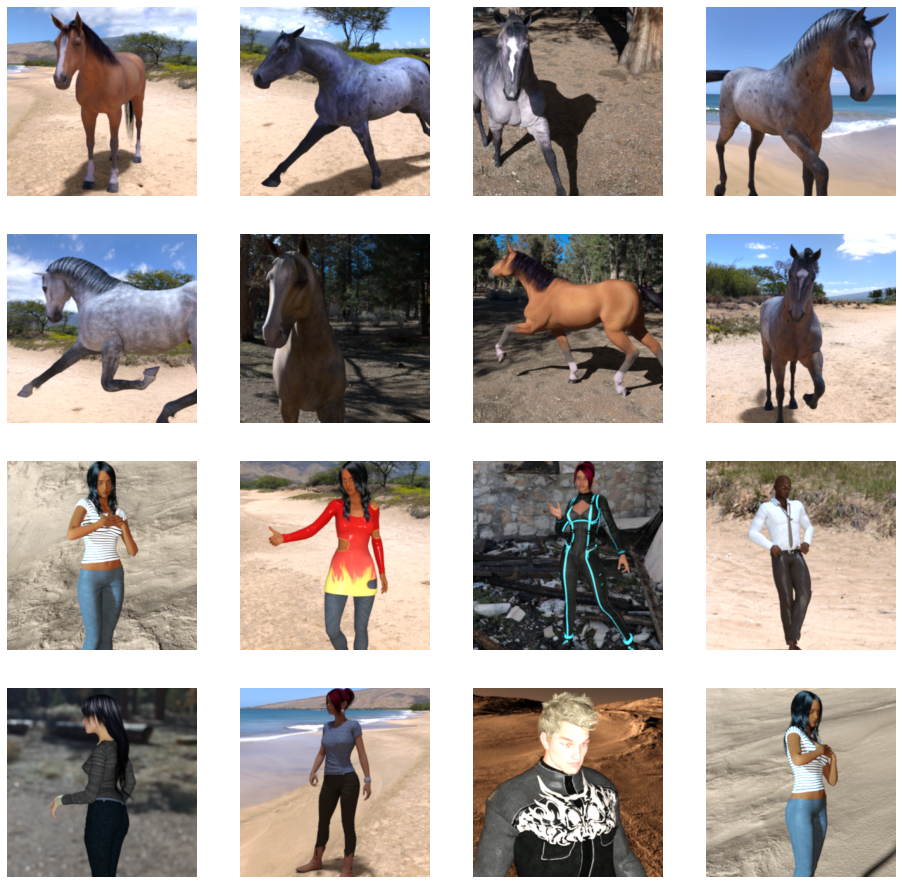

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# modelimizi kurmaya başlayalım

In [10]:
import tensorflow as tf

In [11]:
x = tf.keras.layers
model = tf.keras.models.Sequential([
    #1. katman
    x.Conv2D(16,(3,3),activation="relu",input_shape=(300,300,3)),
    x.MaxPooling2D(2,2),
    #2. katman
    x.Conv2D(32,(3,3),activation="relu"),
    x.MaxPooling2D(2,2),
    #3. katman
    x.Conv2D(64,(3,3),activation="relu"),
    x.MaxPooling2D(2,2),
    #4. katman
    x.Conv2D(64,(3,3),activation="relu"),
    x.MaxPooling2D(2,2),
    #5. katman
    x.Conv2D(64,(3,3),activation="relu"),
    x.MaxPooling2D(2,2),
    #Flatten katmanı
    x.Flatten(),
    x.Dense(512,activation="relu"),
    x.Dense(1,activation="sigmoid")

])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

modelimizi derleyelim / compile edelim

In [13]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss="binary_crossentropy",
              optimizer=RMSprop(lr=0.001),
              metrics=["accuracy"])

**loss="binary_crossentropy"** oldu çünkü bu bir **ikili sınıflandırma** problemi.

Ayrıca **optimizer** olarak **RMSprop** seçtik. Öğrenme oranını otomatik olarak ayarlar.(Adam,Adagrad da buna benzer çalışır. Bir fark yoktur.)

# Verimiz için **ön hazırlık**/**preprocessing** yapalım

Daha önceden de bahsettiğimiz işlem sırasında kolaylık olamsı için pixel değerlerini [0,255]'ten alıp [0,1] arasına çekeceğiz ; **Normalleştirme işlemi**/**Normalization**.

Bunu yaparken elle yapmak yerine bunu yapan sınıf olan ***ImageDataGenerator***'ü kullanacağız.Buradaki **rescale** parametresi bize çok yarayacaktır.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    "/tmp/horse-or-human",
    target_size=(300,300),
    batch_size=128,
    class_mode="binary"
)

Found 1027 images belonging to 2 classes.


**class_mode="binary"** binary_crossentropy'yi kullandığımız için bize **binary label**'lar lazım

# şimdi **training** / **eğitim** yapalım

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=8,
    epochs=15,
    verbose=1
)

Epoch 1/15
8/8 [==============================] - 6s 759ms/step - loss: 0.8071 - accuracy: 0.5706
Epoch 2/15
8/8 [==============================] - 5s 683ms/step - loss: 0.9553 - accuracy: 0.6852
Epoch 3/15
8/8 [==============================] - 5s 683ms/step - loss: 0.7015 - accuracy: 0.8076
Epoch 4/15
8/8 [==============================] - 5s 650ms/step - loss: 0.3563 - accuracy: 0.8487
Epoch 5/15
8/8 [==============================] - 5s 656ms/step - loss: 0.2861 - accuracy: 0.8910
Epoch 6/15
8/8 [==============================] - 5s 661ms/step - loss: 0.1761 - accuracy: 0.9355
Epoch 7/15
8/8 [==============================] - 6s 759ms/step - loss: 0.3951 - accuracy: 0.8818
Epoch 8/15
8/8 [==============================] - 5s 650ms/step - loss: 0.2965 - accuracy: 0.8865
Epoch 9/15
8/8 [==============================] - 5s 652ms/step - loss: 0.3202 - accuracy: 0.8910
Epoch 10/15
8/8 [==============================] - 5s 652ms/step - loss: 0.1384 - accuracy: 0.9577
Epoch 11/15
8/8 [==

# şimdi modelimizi **deneyelim**

In [16]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

Saving at.jfif to at.jfif
[0.]
at.jfif is a horse


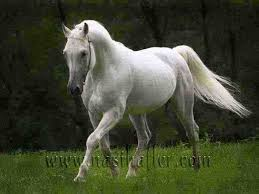

Görüntümüz buydu. Model doğru tahmin verdi.